# 0. Install packages

In [ ]:
%%capture
%env OPENAI_API_KEY=your-key-here

In [140]:
%%capture
%pip install openai Pillow pandas langchain-openai langchain-community lancedb langchain-experimental open_clip_torch torch matplotlib requests

# 1. Preprocess Dataset

In [34]:
import pandas as pd

df = pd.read_csv("poems/IT298-FuzzyPoetryDataset.csv")
display(df.head())
display(df.count())

Name            Poem Title Poem Author  \
0  Andrew Welling  The Abracadabra Boys    Sandburg   
1  Andrew Welling  The Abracadabra Boys    Sandburg   
2  Andrew Welling  The Abracadabra Boys    Sandburg   
3  Andrew Welling  The Abracadabra Boys    Sandburg   
4  Andrew Welling  The Abracadabra Boys    Sandburg   

                                           Poem Text  \
0  The abracadabra boyshave they been in the stac...   
1  They know postures from impostures, pistils fr...   
2  They give with passwords. Who cometh? A kumqua...   
3  Do they have fun? Suretheir fun is being what ...   
4  Pointing at you, at us, at the rabble, they si...   

                                    Image Source URL  \
0  https://unsplash.com/photos/united-states-circ...   
1  https://unsplash.com/photos/red-and-yellow-pai...   
2  https://unsplash.com/photos/a-couple-of-people...   
3  https://images.unsplash.com/photo-163129507612...   
4  https://unsplash.com/photos/a-group-of-people-...   

                                   Google Drive Link  
0  https://drive.google.com/file/d/1ve8tcIBnUJ4HE...  
1  https://drive.google.com/file/d/14Q_57lQdkZcTa...  
2  https://drive.google.com/file/d/13YIV-cxm5nYKu...  
3  https://drive.google.com/file/d/1aJnT31iLtrI_W...  
4  https://drive.google.com/file/d/1NUajrfRVwdG60...

Name                 472
Poem Title           471
Poem Author          470
Poem Text            472
Image Source URL     471
Google Drive Link    444
dtype: int64

In [36]:
import re


def convert_google_drive_url(view_url: str) -> str:
    """
    Converts a Google Drive 'view' URL to a direct download URL.

    Args:
        view_url: The original Google Drive URL in the format
                  "https://drive.google.com/file/d/FILE_ID/view?..."

    Returns:
        The direct download URL in the format
        "https://drive.usercontent.google.com/download?id=FILE_ID"
        Returns an empty string if the ID cannot be extracted.
    """
    # Use a regular expression to find the file ID
    match = re.search(
        r"https://drive\.google\.com/file/d/([a-zA-Z0-9_-]+)/view", view_url
    )
    if match:
        file_id = match.group(1)
        return f"https://drive.usercontent.google.com/download?id={file_id}"
    else:
        return


df["download_image_url"] = (
    df["Google Drive Link"].astype(str).apply(convert_google_drive_url)
)
df_cleaned = df.dropna(subset=["download_image_url"])
display(df_cleaned.head())
display(df_cleaned.count())

Name            Poem Title Poem Author  \
0  Andrew Welling  The Abracadabra Boys    Sandburg   
1  Andrew Welling  The Abracadabra Boys    Sandburg   
2  Andrew Welling  The Abracadabra Boys    Sandburg   
3  Andrew Welling  The Abracadabra Boys    Sandburg   
4  Andrew Welling  The Abracadabra Boys    Sandburg   

                                           Poem Text  \
0  The abracadabra boyshave they been in the stac...   
1  They know postures from impostures, pistils fr...   
2  They give with passwords. Who cometh? A kumqua...   
3  Do they have fun? Suretheir fun is being what ...   
4  Pointing at you, at us, at the rabble, they si...   

                                    Image Source URL  \
0  https://unsplash.com/photos/united-states-circ...   
1  https://unsplash.com/photos/red-and-yellow-pai...   
2  https://unsplash.com/photos/a-couple-of-people...   
3  https://images.unsplash.com/photo-163129507612...   
4  https://unsplash.com/photos/a-group-of-people-...   

                                   Google Drive Link  \
0  https://drive.google.com/file/d/1ve8tcIBnUJ4HE...   
1  https://drive.google.com/file/d/14Q_57lQdkZcTa...   
2  https://drive.google.com/file/d/13YIV-cxm5nYKu...   
3  https://drive.google.com/file/d/1aJnT31iLtrI_W...   
4  https://drive.google.com/file/d/1NUajrfRVwdG60...   

                                  download_image_url  
0  https://drive.usercontent.google.com/download?...  
1  https://drive.usercontent.google.com/download?...  
2  https://drive.usercontent.google.com/download?...  
3  https://drive.usercontent.google.com/download?...  
4  https://drive.usercontent.google.com/download?...

Name                  442
Poem Title            442
Poem Author           441
Poem Text             442
Image Source URL      442
Google Drive Link     442
download_image_url    442
dtype: int64

# 2. Ingest Images into LanceDB

In [ ]:
# %rm -rf './lancedb'

In [ ]:
CREATE_TABLE = True
TABLE_NAME = "images"
DB_PATH = "./lancedb"

In [ ]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
from typing import Optional

db = lancedb.connect(DB_PATH)
func = get_registry().get("open-clip").create()


class Images(LanceModel):
    id: int
    student: str
    title: Optional[str] = None
    author: Optional[str] = None
    poem: str
    download_image_url: str
    google_drive_link: str
    image_uri: str
    image_bytes: bytes = func.SourceField()  # image bytes as the source
    vec_from_bytes: Vector(func.ndims()) = func.VectorField()  # Another vector column

In [110]:
import requests

df_cleaned["image_bytes"] = (
    df_cleaned["download_image_url"]
    .astype(str)
    .apply(lambda x: requests.get(x).content if x else None)
)

/var/folders/wp/6wq8kmb512qgqhymv3320l500000gn/T/ipykernel_63820/980800480.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["image_bytes"] = (


In [124]:
df_cleaned.rename(
    columns={
        "Name": "student",
        "Poem Title": "title",
        "Poem Author": "author",
        "Poem Text": "poem",
        "Image Source URL": "image_uri",
        "Google Drive Link": "google_drive_link",
    },
    inplace=True,
)
df_cleaned["id"] = df_cleaned.index

/var/folders/wp/6wq8kmb512qgqhymv3320l500000gn/T/ipykernel_63820/1823985037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.rename(
/var/folders/wp/6wq8kmb512qgqhymv3320l500000gn/T/ipykernel_63820/1823985037.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["id"] = df_cleaned.index


In [ ]:
df_cleaned.to_parquet("./poems/df_cleaned.parquet", index=False)

In [126]:
df_cleaned.head(5)

student                 title    author  \
0  Andrew Welling  The Abracadabra Boys  Sandburg   
1  Andrew Welling  The Abracadabra Boys  Sandburg   
2  Andrew Welling  The Abracadabra Boys  Sandburg   
3  Andrew Welling  The Abracadabra Boys  Sandburg   
4  Andrew Welling  The Abracadabra Boys  Sandburg   

                                                poem  \
0  The abracadabra boyshave they been in the stac...   
1  They know postures from impostures, pistils fr...   
2  They give with passwords. Who cometh? A kumqua...   
3  Do they have fun? Suretheir fun is being what ...   
4  Pointing at you, at us, at the rabble, they si...   

                                           image_uri  \
0  https://unsplash.com/photos/united-states-circ...   
1  https://unsplash.com/photos/red-and-yellow-pai...   
2  https://unsplash.com/photos/a-couple-of-people...   
3  https://images.unsplash.com/photo-163129507612...   
4  https://unsplash.com/photos/a-group-of-people-...   

                                   google_drive_link  \
0  https://drive.google.com/file/d/1ve8tcIBnUJ4HE...   
1  https://drive.google.com/file/d/14Q_57lQdkZcTa...   
2  https://drive.google.com/file/d/13YIV-cxm5nYKu...   
3  https://drive.google.com/file/d/1aJnT31iLtrI_W...   
4  https://drive.google.com/file/d/1NUajrfRVwdG60...   

                                  download_image_url  \
0  https://drive.usercontent.google.com/download?...   
1  https://drive.usercontent.google.com/download?...   
2  https://drive.usercontent.google.com/download?...   
3  https://drive.usercontent.google.com/download?...   
4  https://drive.usercontent.google.com/download?...   

                                         image_bytes  id  
0  b'\x00\x00\x00 ftypavif\x00\x00\x00\x00avifmif...   0  
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...   1  
2  b'\x00\x00\x00 ftypavif\x00\x00\x00\x00avifmif...   2  
3  b'\x00\x00\x00 ftypavif\x00\x00\x00\x00avifmif...   3  
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01...   4

In [129]:
if CREATE_TABLE:
    # db.drop_table("images")
    table = db.create_table("images", schema=Images)
    table.add(df_cleaned)
else:
    table = db.get_table(TABLE_NAME)

  0%|          | 0/64 [00:00<?, ?it/s]/Users/riley/.pyenv/versions/3.13.5/lib/python3.13/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 45%|████▌     | 29/64 [00:00<00:00, 52.57it/s]/Users/riley/.pyenv/versions/3.13.5/lib/python3.13/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 58/58 [00:00<00:00, 58.80it/s]


In [130]:
table.search().to_pandas()

id         student                                title  \
0      0  Andrew Welling                 The Abracadabra Boys   
1      1  Andrew Welling                 The Abracadabra Boys   
2      2  Andrew Welling                 The Abracadabra Boys   
3      3  Andrew Welling                 The Abracadabra Boys   
4      4  Andrew Welling                 The Abracadabra Boys   
..   ...             ...                                  ...   
437  461  Talia Thompson  One Sister have I in our house (14)   
438  462  Talia Thompson  One Sister have I in our house (14)   
439  463  Talia Thompson  One Sister have I in our house (14)   
440  464  Talia Thompson                               Sonnet   
441  465  Talia Thompson                               Sonnet   

                        author  \
0                     Sandburg   
1                     Sandburg   
2                     Sandburg   
3                     Sandburg   
4                     Sandburg   
..                         ...   
437            Emily Dickinson   
438            Emily Dickinson   
439            Emily Dickinson   
440  Alice Moore Dunbar-Nelson   
441  Alice Moore Dunbar-Nelson   

                                                  poem  \
0    The abracadabra boyshave they been in the stac...   
1    They know postures from impostures, pistils fr...   
2    They give with passwords. Who cometh? A kumqua...   
3    Do they have fun? Suretheir fun is being what ...   
4    Pointing at you, at us, at the rabble, they si...   
..                                                 ...   
437  Today is far from Childhood -\nBut up and down...   
438  And still her hum \nThe years among,        \n...   
439  I spilt the dew -\nBut took the morn, -       ...   
440  I had no thought of violets of late,\nThe wild...   
441  And cabarets and songs, and deadening wine.\nS...   

                                    download_image_url  \
0    https://drive.usercontent.google.com/download?...   
1    https://drive.usercontent.google.com/download?...   
2    https://drive.usercontent.google.com/download?...   
3    https://drive.usercontent.google.com/download?...   
4    https://drive.usercontent.google.com/download?...   
..                                                 ...   
437  https://drive.usercontent.google.com/download?...   
438  https://drive.usercontent.google.com/download?...   
439  https://drive.usercontent.google.com/download?...   
440  https://drive.usercontent.google.com/download?...   
441  https://drive.usercontent.google.com/download?...   

                                     google_drive_link  \
0    https://drive.google.com/file/d/1ve8tcIBnUJ4HE...   
1    https://drive.google.com/file/d/14Q_57lQdkZcTa...   
2    https://drive.google.com/file/d/13YIV-cxm5nYKu...   
3    https://drive.google.com/file/d/1aJnT31iLtrI_W...   
4    https://drive.google.com/file/d/1NUajrfRVwdG60...   
..                                                 ...   
437  https://drive.google.com/file/d/1kH-JrJtiRPa8L...   
438  https://drive.google.com/file/d/1Moz1YRyrcvgEr...   
439  https://drive.google.com/file/d/13Cjn2aGIh1F38...   
440  https://drive.google.com/file/d/1baol1n_WQz3dp...   
441  https://drive.google.com/file/d/12XKZuExCfZN93...   

                                             image_uri  \
0    https://unsplash.com/photos/united-states-circ...   
1    https://unsplash.com/photos/red-and-yellow-pai...   
2    https://unsplash.com/photos/a-couple-of-people...   
3    https://images.unsplash.com/photo-163129507612...   
4    https://unsplash.com/photos/a-group-of-people-...   
..                                                 ...   
437  https://cdn.pixabay.com/photo/2020/06/21/09/48...   
438  https://media.istockphoto.com/id/494243970/pho...   
439  https://cdn.pixabay.com/photo/2020/11/14/17/50...   
440  https://cdn.pixabay.com/photo/2017/07/19/08/05...   
441  https://cdn.pixabay.com/photo/2012/10/30/15/55...   

                            

In [131]:
from PIL import Image
import io

# image search
query_image_uri = "http://farm1.staticflickr.com/200/467715466_ed4a31801f_z.jpg"
image_bytes = requests.get(query_image_uri).content
query_image = Image.open(io.BytesIO(image_bytes))

# image search using a custom vector column
other = (
    table.search(query_image, vector_column_name="vec_from_bytes")
    .limit(1)
    .to_pydantic(Images)[0]
)
print(other.google_drive_link)

https://drive.google.com/file/d/1LMuDd4G4tLWt13DCIZOZ97khsbv5xZyJ/view?usp=sharing


# 3. Use RAG to Create Poem from Image

In [223]:
from typing import List
from openai import OpenAI
import urllib.request
from IPython.display import display
import matplotlib.pyplot as plt
from pydantic import BaseModel


def display_images_with_text(image_list: List[Images]):
    """
    Displays a list of PIL Image objects with their associated text
    in a matplotlib figure with subplots.

    Args:
        image_list: A list of dictionaries, where each dictionary contains
                    "image" (PIL Image object) and "text" (string).
    """
    num_images = len(image_list)
    if num_images == 0:
        print("No images to display.")
        return

    # Determine grid size: aim for a somewhat square layout
    cols = min(4, num_images)  # Max 4 columns to avoid making images too small
    rows = (num_images + cols - 1) // cols  # Calculate rows needed

    # Create a figure and a set of subplots
    # figsize can be adjusted based on the number of images and desired output size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 10))

    # Flatten the axes array if there's more than one row/column,
    # so we can iterate over it easily.
    if num_images == 1:
        axes = [axes]  # Make it iterable if only one subplot
    else:
        axes = axes.flatten()

    for i, img_info in enumerate(image_list):
        ax = axes[i]

        # Display the image
        img = Image.open(io.BytesIO(img_info.image_bytes)).convert("RGB")
        ax.imshow(img)

        # Set the title (associated text) for the subplot
        ax.set_title(img_info.poem, fontsize=10, wrap=True)  # wrap=True for long titles

        # Remove axis ticks and labels for cleaner display
        ax.axis("off")

    # Hide any unused subplots if num_images is not a perfect fit for the grid
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to prevent titles from overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()


def display_image(url: str):
    try:
        response = urllib.request.urlopen(url)
        image_data = response.read()
        img = Image.open(io.BytesIO(image_data))
        # img.show()
        display(img)
    except Exception as e:
        print(f"Error opening image from URL: {e}")


def get_top_k_rows(image: Image, k: int = 2) -> List[Images]:
    """
    Search for the top k poems based on the input image.

    Args:
        image: The input image to search for.
        k: The number of top results to return.

    Returns:
        A DataFrame containing the top k poems and their metadata.
    """
    return (
        table.search(image, vector_column_name="vec_from_bytes")
        .limit(k)
        .to_pydantic(Images)
    )


def format_RAG_prompt(rows: List[Images]) -> str:
    """
    Format the retrieved rows into a prompt for RAG.

    Args:
        rows: The list of retrieved rows containing poem metadata.

    Returns:
        A formatted string prompt for RAG.
    """
    prompt = "Construct a new segment using the following context:\n\n"
    for row in rows:
        # prompt += f"Title: {row.title}\n"
        # prompt += f"Author: {row.author}\n"
        prompt += f"Poem: {row.poem}\n\n"
    return prompt + "Respond only with the segment."


class Poem(BaseModel):
    verses: str


def generate_poem_from_image(
    image_uri: str, client: OpenAI = None, k=5, model="gpt-4.1-nano", show_context=False
) -> str:
    if client is None:
        client = OpenAI()
    image_bytes = requests.get(image_uri).content
    query_image = Image.open(io.BytesIO(image_bytes))
    rows = get_top_k_rows(query_image, k)
    if show_context:
        display_images_with_text(rows)
    prompt = format_RAG_prompt(rows)
    return client.responses.create(model=model, input=prompt)
    # return client.responses.parse(model=model, input=prompt, text_format=Poem)

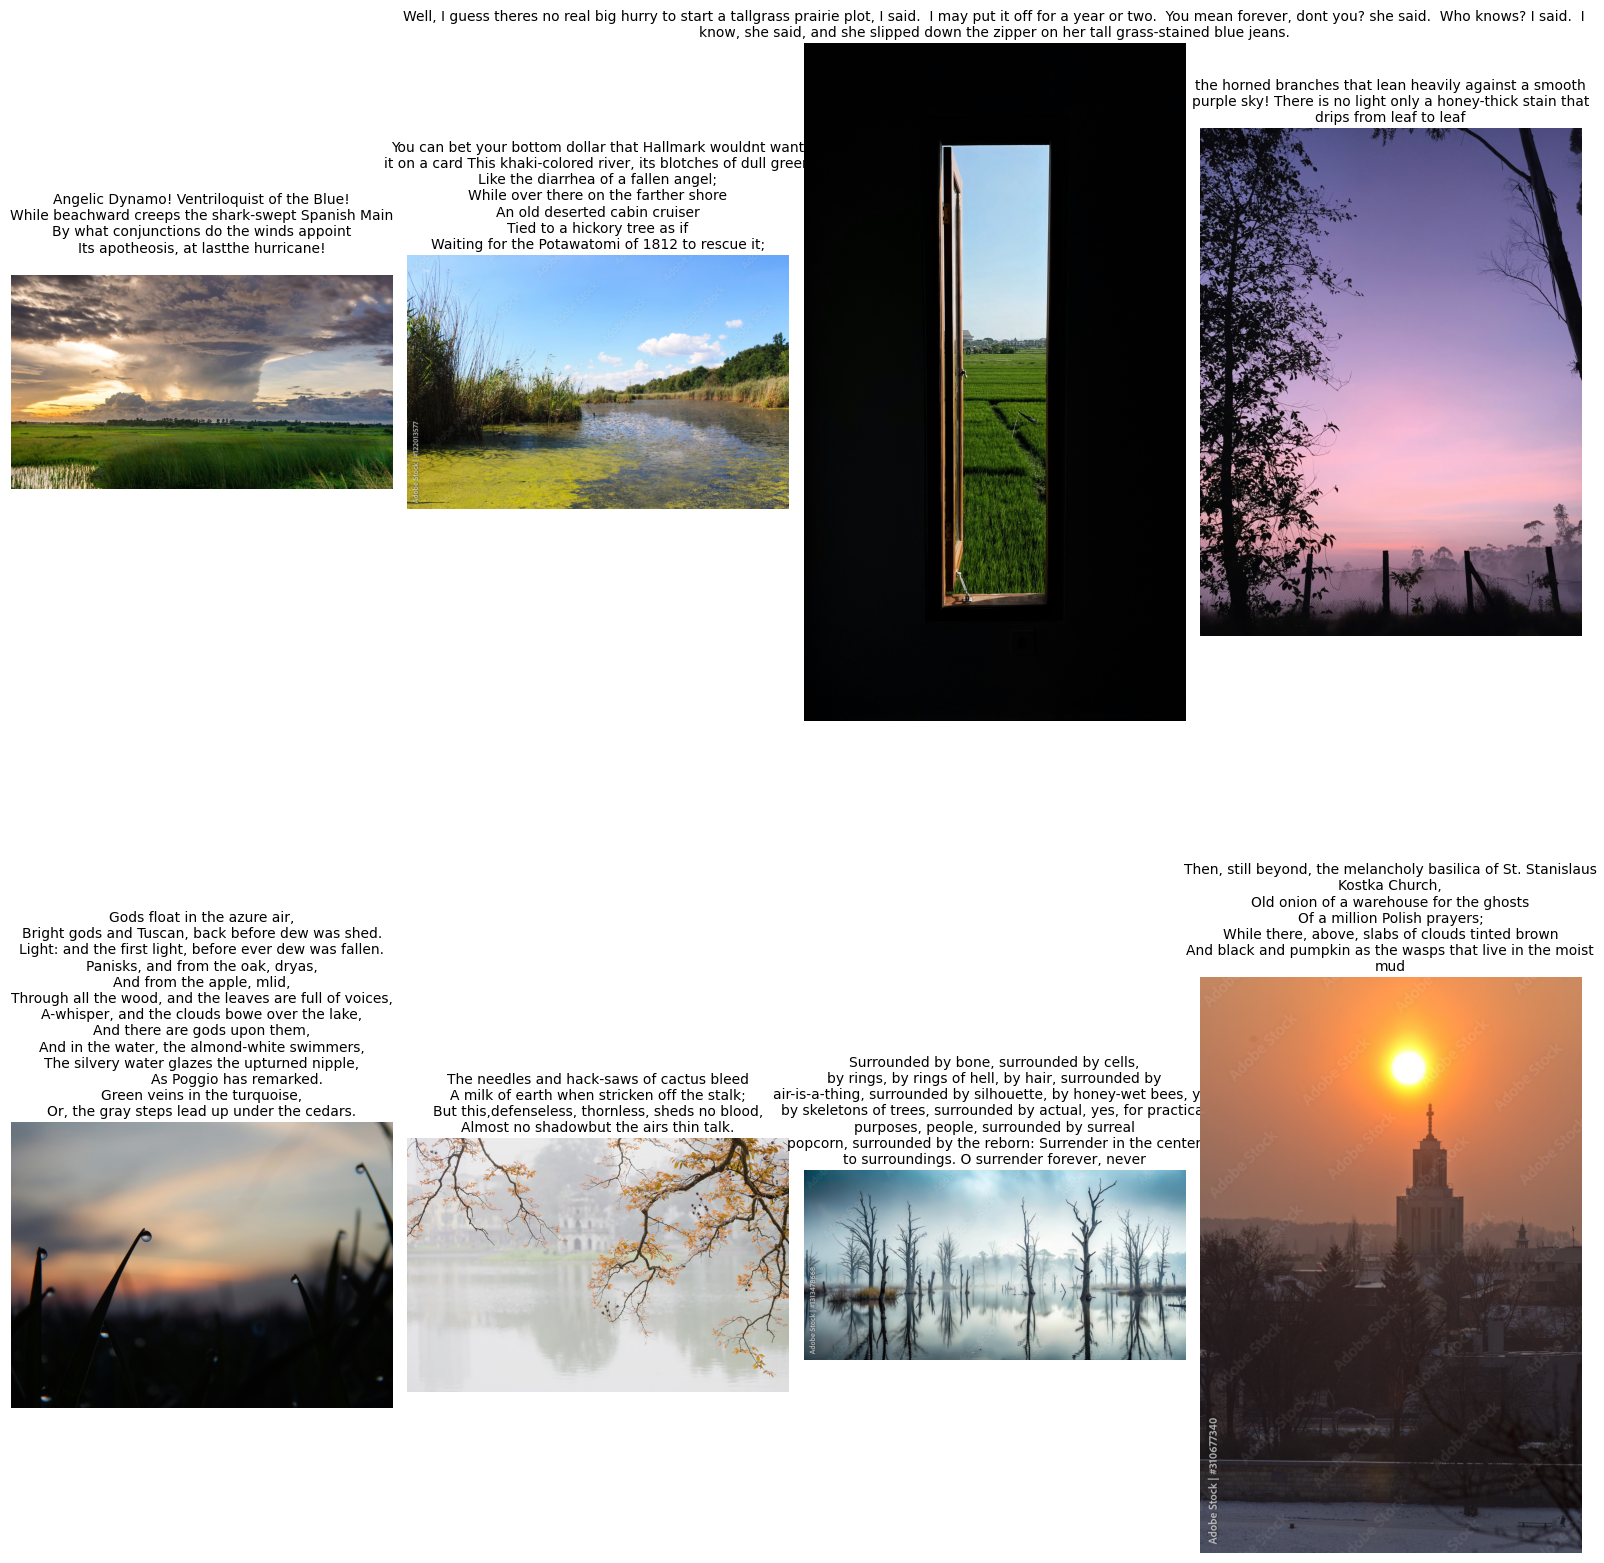

Beneath the fractured sky where whispers drift like loose threads,
The city pulse pulses softly—its veins clogged with memories
And shadows stretching long across cracked pavement.
Here, in the silence of fading echoes, a ghostly presence stirs,
An unyielding hum, a flicker of electric hope in the void.
Fingers of dusk clutch the horizon, pinning dreams of concrete and steel,
While distant sirens wail beneath the ghostly moon,
A song of resilience woven into the fabric of the night.
And in this half-light, where ghosts and man coalesce,
A flame of dawn patiently awakens, promising anew.


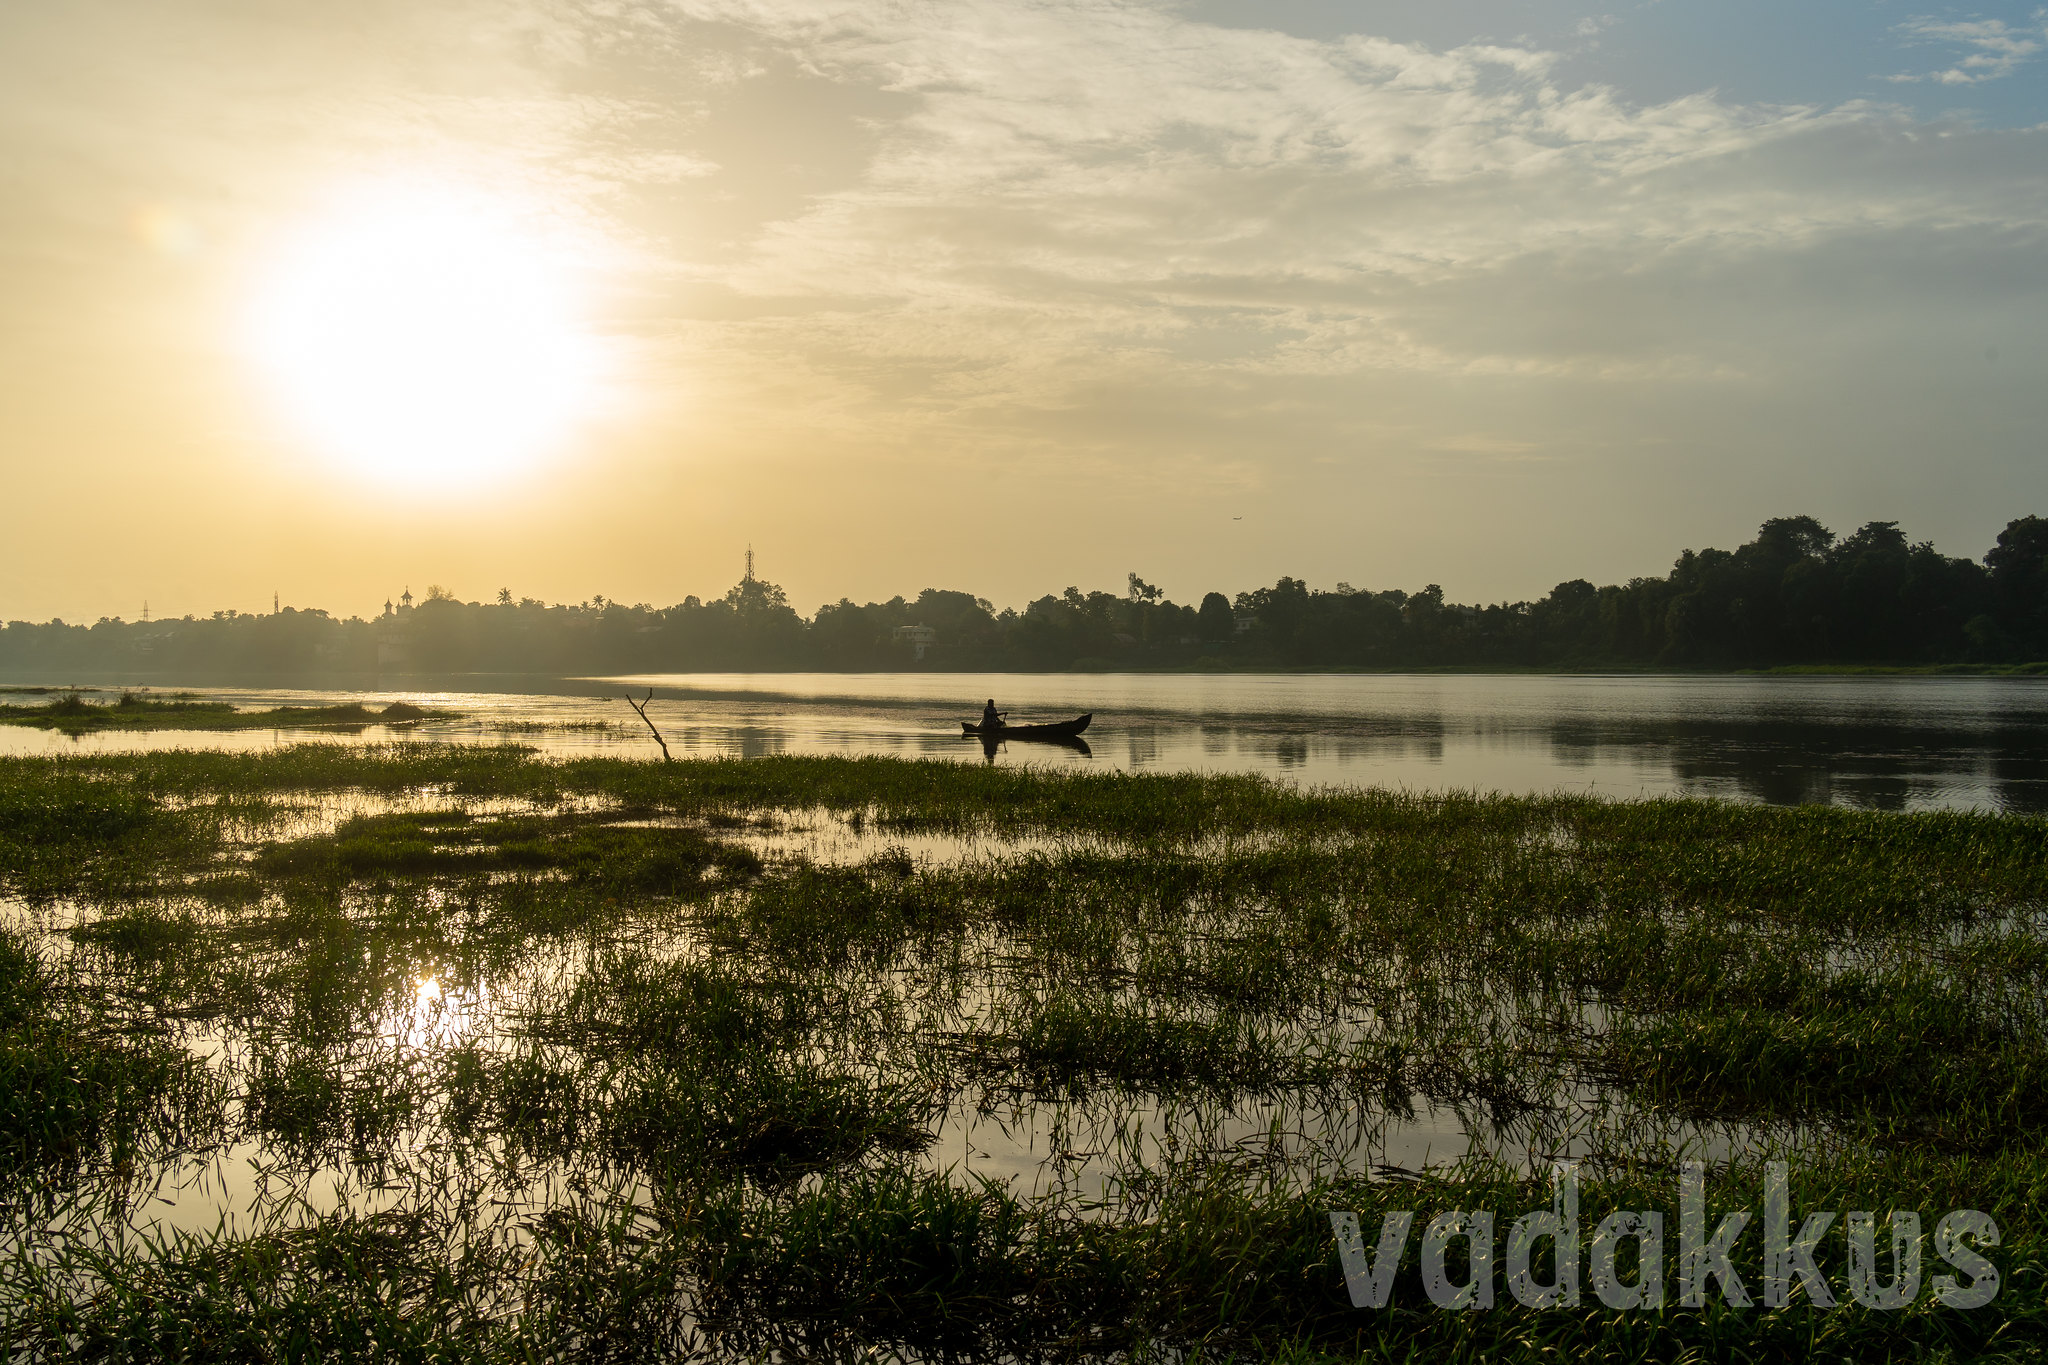

In [237]:
query_image_uri = "http://farm1.staticflickr.com/200/467715466_ed4a31801f_z.jpg"
query_image_uri = "https://live.staticflickr.com/65535/54638556216_146f8ac2b6_k.jpg"
response = generate_poem_from_image(query_image_uri, k=8, show_context=True)
print(response.output_text)
# print(response.output_parsed.verses)
display_image(query_image_uri)